# Transfer Learning

In [1]:
%matplotlib inline

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

import tarfile
import csv
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from scipy.ndimage import imread

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit

# Getting VGGNet and Flower Image Dataset

## VGGNetLoader

In [2]:
class VGGNetLoader:
    
    def load_vgg(self, vgg_dir='tensorflow_vgg/'):
        """
        Load VGGNet.
        """
        
        print('\nLoading VGGNet ...\n')
        
        if not isdir(vgg_dir):
            raise Exception("VGG directory doesn't exist!")
            
        if not isfile(vgg_dir + "vgg16.npy"):
            with DLProgress(
                unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
                urlretrieve(
                    'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
                    vgg_dir + 'vgg16.npy',
                    pbar.hook)
        else:
            print("VGG parameter file already exists!")
            
        print('\nVGGNet loaded\n')

### DLProgress

In [3]:
class DLProgress(tqdm):
    
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

## ImageDataLoader

In [4]:
class ImageDataLoader:
    
    def load_flower_images(self, data_dir='flower_photos/'):
        """
        Load flower image dataset.
        """
        print('\nLoading flower image dataset ...\n')
        
        if not isfile('flower_photos.tar.gz'):
            with DLProgress(
                unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
                urlretrieve(
                    'http://download.tensorflow.org/example_images/flower_photos.tgz',
                    'flower_photos.tar.gz',
                    pbar.hook)

        if not isdir(data_dir):
            with tarfile.open('flower_photos.tar.gz') as tar:
                tar.extractall()
                tar.close()
                
        print('Flower image dataset loaded\n')

In [5]:
vggLoader = VGGNetLoader()

vggLoader.load_vgg()

VGG16 Parameters: 0.00B [00:00, ?B/s]


Loading VGGNet ...



VGG16 Parameters: 553MB [00:29, 18.5MB/s]                              


VGGNet loaded



In [6]:
imageDataLoader = ImageDataLoader()

imageDataLoader.load_flower_images()

Flowers Dataset: 0.00B [00:00, ?B/s]


Loading flower image dataset ...



Flowers Dataset: 229MB [00:05, 43.7MB/s]                              


Flower image dataset loaded



# Building and Running VGGNet

In [7]:
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

## VGGGraphBuilder

In [8]:
class VGGGraphBuilder:
    
    def build_vgg_graph(self, input_, name_scope=None):
        """
        Build VGG network graph.
        """
        
        print('\nBuilding VGG network graph ...\n')
        
        vgg = vgg16.Vgg16()
        
        if name_scope == None:
            vgg.build(input_)
        else:
            with tf.name_scope(name_scope):
                vgg.build(input_)
        
        print('\nVGG network graph built\n')
        
        return vgg

## VGGNetRunner

In [9]:
class VGGNetRunner:
    
    def run_vgg(self, name_scope, data_dir, batch_size, img_shape, img_classes):
        """
        Build and run VGG network on flower image data.
        : name_scope: Name scope to use to build VGG network graph
        : data_dir: Data directory
        : batch_size: Batch size
        : img_shape: Shape of input image (24x24x3)
        : img_classes: Image classes
        """
        
        print('\nBuilding and running VGG network on flower image dataset ...\n')
        
        codes = None
        labels = []
        batch = []
        
        with tf.Session() as sess:
            # Build vgg network
            input_ = tf.placeholder(tf.float32, [None, *img_shape])
            vgg = VGGGraphBuilder().build_vgg_graph(input_, name_scope)
                
            # Run vgg network
            for each in img_classes:
                print('\nStarting {} images\n'.format(each))
                
                img_class_path = data_dir + each
                files = os.listdir(img_class_path)
                
                for ii, file in enumerate(files, 1):
                    # Add images to the current batch
                    # utils.load_image crops the input images for us, from the center
                    img = utils.load_image(os.path.join(img_class_path, file))
                    batch.append(img.reshape((1, *img_shape)))
                    labels.append(each)
                    
                    # Run the batch through the network to get the image codes
                    if ii % batch_size == 0 or ii == len(files):
                        # Image batch to pass to VGG network
                        batch_images = np.concatenate(batch)
                        
                        # Get the values from the relu6 layer of the VGG network
                        feed_dict = {input_: batch_images}
                        batch_img_codes = sess.run(vgg.relu6, feed_dict=feed_dict)
                        
                        # Build array of image codes
                        if codes is None:
                            codes = batch_img_codes
                        else:
                            codes = np.concatenate((codes, batch_img_codes))
                            
                        # Rest to start building the next batch
                        batch = []
                        
                        print('{} images processed'.format(ii))
        
        print('\nRunning complete\n')
        
        return codes, labels

## DataWriterReader

In [10]:
class DataWriterReader:
    
    def write_codes_to_file(self, codes):
        with open('codes', 'w') as f:
            codes.tofile(f)
        print('\nSaved codes to file')
            
    def write_labels_to_file(self, labels):
        with open('labels', 'w') as f:
            writer = csv.writer(f, delimiter='\n')
            writer.writerow(labels)
        print('Saved labels to file\n')
            
    def read_codes_from_file(self, n_labels):
        with open('codes', 'r') as f:
            codes = np.fromfile(f, dtype=np.float32)
            codes = codes.reshape((n_labels, -1))
            print('\nRetrieved codes from file')
            return codes
        
    def read_labels_from_file(self):
        with open('labels', 'r') as f:
            reader = csv.reader(f, delimiter='\n')
            labels = np.array([each for each in reader if len(each) > 0]).squeeze()
            print('Retrieved labels from file\n')
            return labels

In [11]:
name_scope = 'content_vgg'
data_dir = 'flower_photos/'
batch_size = 10
img_shape = (224, 224, 3)
contents = os.listdir(data_dir)
img_classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [12]:
vggRunner = VGGNetRunner()

codes, labels = vggRunner.run_vgg(name_scope, data_dir, batch_size, img_shape, img_classes)


Building and running VGG network on flower image dataset ...


Building VGG network graph ...

/output/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s

VGG network graph built


Starting sunflowers images

10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 imag

In [13]:
dataWriterReader = DataWriterReader()

dataWriterReader.write_codes_to_file(codes)
dataWriterReader.write_labels_to_file(labels)


Saved codes to file
Saved labels to file



# Preparing Data

## DataPreparer

In [14]:
class DataPreparer:
    
    def one_hot_encode(self, labels):
        """
        One-hot-encode labels.
        """
        lb = LabelBinarizer()
        lb.fit(labels)
        labels_vecs = lb.transform(labels)
        print('\nOne-hot-encoded labels')
        return labels_vecs
    
    def create_train_val_test_sets(self, codes, labels_vecs, n_splits=1, test_size=0.2):
        """
        Create training, valiation, and test datasets.
        """
        
        print('\nCreating training, validation, and test datsets ...\n')
        
        ss = StratifiedShuffleSplit(n_splits, test_size)
        
        train_idx, val_idx = next(ss.split(codes, labels_vecs))
        
        half_val_len = int(len(val_idx)/2)
        
        val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]
        
        train_x, train_y = codes[train_idx], labels_vecs[train_idx]
        val_x, val_y     = codes[val_idx],   labels_vecs[val_idx]
        test_x, test_y   = codes[test_idx],  labels_vecs[test_idx]
        
        print("Train shapes (x, y):", train_x.shape, train_y.shape)
        print("Validation shapes (x, y):", val_x.shape, val_y.shape)
        print("Test shapes (x, y):", test_x.shape, test_y.shape)
        
        print('\nCreated train, val, test sets\n')
        
        return train_x, train_y, val_x, val_y, test_x, test_y

In [15]:
codes = dataWriterReader.read_codes_from_file(len(labels))
labels = dataWriterReader.read_labels_from_file()


Retrieved codes from file
Retrieved labels from file



In [16]:
n_splits = 1
test_size = 0.2

In [17]:
dataPreparer = DataPreparer()

labels_vecs = dataPreparer.one_hot_encode(labels)

train_x, train_y, val_x, val_y, test_x, test_y = \
    dataPreparer.create_train_val_test_sets(codes, labels_vecs, n_splits, test_size)


One-hot-encoded labels

Creating training, validation, and test datsets ...

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)

Created train, val, test sets



# Building and Training Image Classifier

## ImageClassifier

In [18]:
class ImageClassifier:
    
    def build(self, code_size, label_size, num_outputs):
        """
        Build image classifier layers and operations.
        """
        
        print('\nBuilding image classifier ...\n')
        
        self.inputs = tf.placeholder(tf.float32, shape=[None, code_size])
        self.labels = tf.placeholder(tf.int64, shape=[None, label_size])
        
        # Fully-connected classifier layer
        fc = tf.contrib.layers.fully_connected(self.inputs, num_outputs)
        
        # Output layer logits
        logits = tf.contrib.layers.fully_connected(fc, label_size, activation_fn=None)
        
        # Cross entropy loss
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,
                                                                logits=logits)
        self.cost = tf.reduce_mean(cross_entropy)
        
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        
        # Operations for validation/test accuracy
        self.predicted = tf.nn.softmax(logits)
        correct_pred = tf.equal(tf.argmax(self.predicted, 1), tf.argmax(self.labels, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        print('Image classifier built\n')

## DataBatchGenerator

In [19]:
class DataBatchGenerator:
    
    def get_batches(self, x, y, n_batches=10):
        """
        Return a generator that yields batches from arrays x and y.
        """
        
        batch_size = len(x)//n_batches
        
        for ii in range(0, n_batches*batch_size, batch_size):
            # If we're not on the last batch, grab data with batch_size
            if ii != (n_batches-1)*batch_size:
                X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size]
            # On the last batch, grab the rest of the data
                X, Y = x[ii:], y[ii:]
                
            yield X, Y

## ModelTrainer

In [20]:
class ModelTrainer:

    def train_model(self, 
                    model, 
                    train_x, train_y, 
                    val_x, val_y,
                    epochs,
                    checkpoint_file):
        """
        Train the image classifier.
        : model: Classifier model to train
        : train_x: Training images
        : train_y: Training labels
        : val_x: Validation images
        : val_y: Validation labels
        : epochs: Number of epochs
        : checkpoint_file: File to save session to
        """
        
        print('\nTraining image classifier ...\n')
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            iteration = 0
            
            for e in range(epochs):
                batches = DataBatchGenerator().get_batches(train_x, train_y)
                
                for x, y in batches:
                    feed = {model.inputs: x, 
                            model.labels: y}
                    
                    loss, _ = sess.run([model.cost, model.optimizer],
                                        feed_dict=feed)
                    
                    print("Epoch: {}/{}".format(e+1, epochs),
                          "Iteration: {}".format(iteration),
                          "Training loss: {:.5f}".format(loss))
                    
                    iteration += 1
                    
                    if iteration % 5 == 0:
                        feed = {model.inputs: val_x,
                                model.labels: val_y}
                        
                        val_acc = sess.run(model.accuracy,
                                           feed_dict=feed)
                        
                        print("Epoch: {}/{}".format(e, epochs),
                              "Iteration: {}".format(iteration),
                              "Validation Acc: {:.4f}".format(val_acc))
            
            saver = tf.train.Saver()
            saver.save(sess, "checkpoints/flowers.ckpt")
            
        print('\nTraining complete\n')

In [21]:
code_size = codes.shape[1]
label_size = labels_vecs.shape[1]
num_outputs = 256

In [22]:
classifier = ImageClassifier()

classifier.build(code_size, label_size, num_outputs)


Building image classifier ...

Image classifier built



In [23]:
epochs = 10
checkpoint_file = "checkpoints/flowers.ckpt"

In [24]:
modelTrainer = ModelTrainer()

modelTrainer.train_model(classifier, 
                         train_x, train_y, 
                         val_x, val_y,
                         epochs,
                         checkpoint_file)


Training image classifier ...

Epoch: 1/10 Iteration: 0 Training loss: 5.67926
Epoch: 1/10 Iteration: 1 Training loss: 19.39539
Epoch: 1/10 Iteration: 2 Training loss: 7.98866
Epoch: 1/10 Iteration: 3 Training loss: 3.51599
Epoch: 1/10 Iteration: 4 Training loss: 3.49844
Epoch: 0/10 Iteration: 5 Validation Acc: 0.6975
Epoch: 1/10 Iteration: 5 Training loss: 3.06774
Epoch: 1/10 Iteration: 6 Training loss: 3.12607
Epoch: 1/10 Iteration: 7 Training loss: 2.54074
Epoch: 1/10 Iteration: 8 Training loss: 1.27616
Epoch: 1/10 Iteration: 9 Training loss: 0.72423
Epoch: 0/10 Iteration: 10 Validation Acc: 0.8447
Epoch: 2/10 Iteration: 10 Training loss: 0.97115
Epoch: 2/10 Iteration: 11 Training loss: 0.84836
Epoch: 2/10 Iteration: 12 Training loss: 0.84216
Epoch: 2/10 Iteration: 13 Training loss: 0.79744
Epoch: 2/10 Iteration: 14 Training loss: 0.74326
Epoch: 1/10 Iteration: 15 Validation Acc: 0.8283
Epoch: 2/10 Iteration: 15 Training loss: 0.67601
Epoch: 2/10 Iteration: 16 Training loss: 0.6040

# Testing Image Classifier

## ModelTester

In [25]:
class ModelTester:

    def test_model(self, model, checkpoint, test_img_path):
        """
        Compute test accuracy of the classifier model.
        : model: Image classifier model to test
        : checkpoint: Name of checkpoint where trained model is saved
        : test_img_path: Path to test image to display
        """
        
        print('\nTesting the image classifier ...\n')
        
        with tf.Session() as sess:
            # Restore trained model
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint(checkpoint))
            
            # Compute model test accuracy
            feed = {model.inputs: test_x,
                    model.labels: test_y}
            
            test_acc = sess.run(model.accuracy,
                                feed_dict=feed)
            
            print("Test accuracy: {:.4f}".format(test_acc))
        
            # Display test image
            test_img = imread(test_img_path)
            plt.imshow(test_img)
            
            # Build and run VGG network on test image
            input_ = tf.placeholder(tf.float32, [None, *img_shape])
            vgg = VGGGraphBuilder().build_vgg_graph(input_)
            
            img = utils.load_image(test_img_path)
            img = img.reshape((1, *img_shape))
            
            feed = {input_: img}
            
            code = sess.run(vgg.relu6, feed_dict=feed)
            
            # Run trained model using VGG output as input
            feed = {model.inputs: code}
            
            prediction = sess.run(model.predicted,
                                  feed_dict=feed).squeeze()
            
            print('Prediction: {}'.format(prediction))
            
        print('\nTesting complete\n')

In [26]:
checkpoint = 'checkpoints'
test_img_path = 'flower_photos/roses/118974357_0faa23cce9_n.jpg'


Testing the image classifier ...

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.8856

Building VGG network graph ...

/output/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s

VGG network graph built

Prediction: [  8.44263314e-20   9.51741822e-31   9.99999881e-01   1.07819363e-22
   1.64738566e-07]

Testing complete



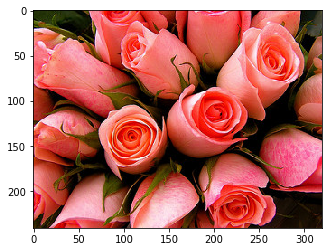

In [27]:
modelTester = ModelTester()

modelTester.test_model(classifier, checkpoint, test_img_path)